# Cleaning the spikes

Before diving into any data analysis endeavor, we must first clean our scans. Raw X-ray CT reconstructions, as most real-life data, is quite messy and there are a number of issues to be addressed. 
- The densities must be standarized as explored in a previous notebook
- Remove the foam and air
- Prune the awns
- Separating individual spikes
- Labeling the spikes according to their position on the foam tray.

Needless to say, this image processing pipeline uses only basic mathematical morphology operations and the parameters are ad-hoc for the data at hand.

<img src="https://www.egr.msu.edu/~amezqui3/barley/figs/barley_lab_composition.jpg" width=500>

In [26]:
import tifffile as tf
import scipy.ndimage as ndimage
import numpy as np
import os
import argparse
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import math
import importlib

# All the image preprocessing functions are found in `barley_brew`

- The `barley_brew` module is simply a repository of _ad hoc_ image processing functions to clean X-ray CT scans
- The module is not meant to be directly used outside the barley project, but rather provide some inspiration of what can be done to address basic X-ray CT cleaning woes.
- Hence, this notebook attempts to flesh out the functions in the module so other readers might be inspired to try similar tricks on their own.

In [27]:
import demeter.barley_brew as brew

## Load the raw scan

We will load `S017.tif`.
- `fname`: filename: `S017.tif`
- `bname`: basename: `S017`

In [28]:
tiff_file = '../../preproc/raw/S070.tif'

src, fname = os.path.split(tiff_file)
src = src + '/'
bname = os.path.splitext(fname)[0]
img = tf.imread(tiff_file)

In [29]:
bname

'S070'

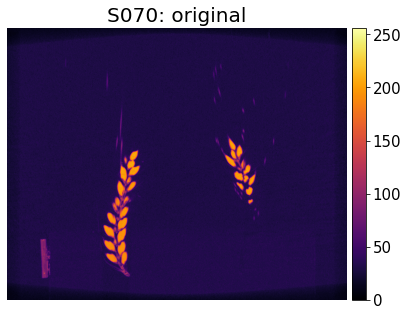

In [38]:
ss = np.s_[:,1300,:]
raw_img = img[ss].copy()
fig, ax = plt.subplots(1, 1, figsize=(10,5))

mag = ax.imshow(raw_img, origin='lower', cmap='inferno', vmin=0, vmax=2**(img.dtype.itemsize*8))
ax.set_title(bname+': original', fontsize=20)
cbar = plt.colorbar(mag, ax=ax, pad=0.01);
cbar.ax.tick_params(labelsize=15) 
ax.axis('off');

## Standardize the density values

Load the coefficients $a,b,c$ of the polynomial adjustment as computed before. 

For each voxel with density value $\rho\in\{0,1,\ldots,255\}$, we compute $f(\rho)=a\rho^2+b\rho+c$.

We then normalize the density values as
$$ g(\rho) = \begin{cases}
255, &\text{if }\; f(\rho) > 255,\\
f(\rho), &\text{if }\; 0\leq f(\rho)\leq 255,\\
0, &\text{if }\; f(\rho)<0.
\end{cases} $$

In [40]:
adjust_by = np.loadtxt(src+'normalize/' + bname+'_yvals.csv', dtype='float', delimiter=',')
print('Polynomials coefficients,\t', adjust_by)
img = brew.normalize_density(img, adjust_by)

Polynomials coefficients,	 [1.76193373e-04 1.04881947e+00 1.28768377e+01]


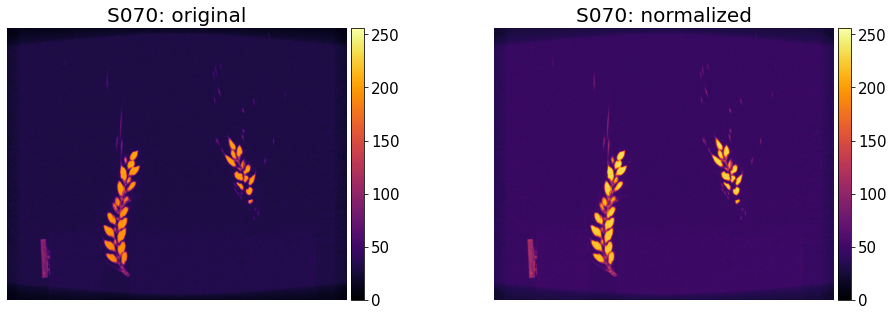

In [41]:
norm_img = img[ss].copy()
fig, ax = plt.subplots(1, 2, figsize=(16,5))

i=0
mag = ax[i].imshow(raw_img, origin='lower', cmap='inferno', vmin=0, vmax=2**(img.dtype.itemsize*8))
ax[i].set_title(bname+': original', fontsize=20)
cbar = plt.colorbar(mag, ax=ax[i], pad=0.01);
cbar.ax.tick_params(labelsize=15) 
ax[i].axis('off');
i=1
mag = ax[i].imshow(norm_img, origin='lower', cmap='inferno', vmin=0, vmax=2**(img.dtype.itemsize*8))
ax[i].set_title(bname+': normalized', fontsize=20)
cbar = plt.colorbar(mag, ax=ax[i], pad=0.01);
cbar.ax.tick_params(labelsize=15) 
ax[i].axis('off');

## Clean the air, foam, and other noise

- The main idea is to threshold out the noise.
- However, some inner parts of the barley have low density and we want to keep them.
- Rather than thresholding immediately, we will first consider a Gaussian blur and then threshold out the voxels such that have low Gaussian blur values.
- The idea is that an air/foam voxel will be surrounded by more air/foam, so its Gaussian blur will be low density.
- On the other hand, a low-density voxel inside the barley will be surrounded by high-density voxels, so its Gaussian blur won't be low density.
- We then threshold *based* on the Gaussian blur, so we retain the original density values.

In [42]:
sigma,thr1 = 3,55
blur = ndimage.gaussian_filter(img, sigma=sigma, mode='constant', truncate=3, cval=0)
img[blur < thr1] = 0

thr_img = img[ss].copy()
blur_img = blur[ss].copy()
mask_img = 1-(blur_img < thr1)

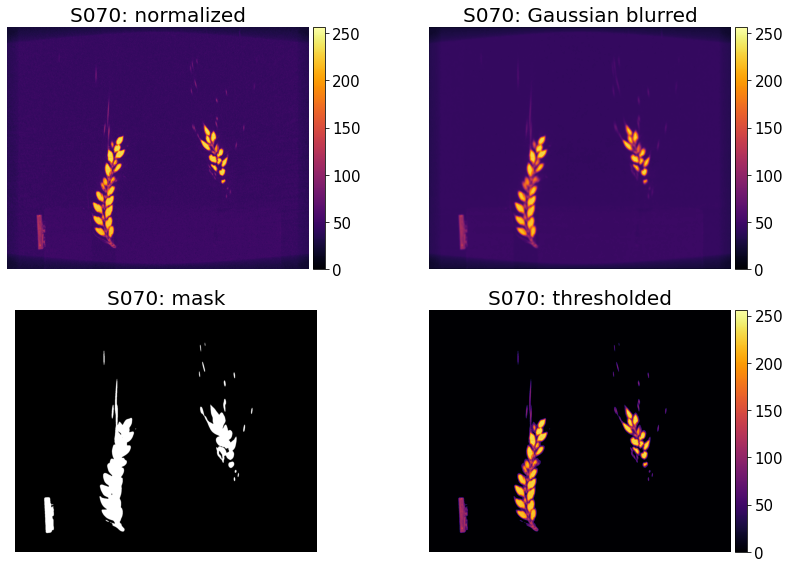

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

i=(0,0)
mag = ax[i].imshow(norm_img, origin='lower', cmap='inferno', vmin=0, vmax=2**(img.dtype.itemsize*8))
ax[i].set_title(bname+': normalized', fontsize=20)
cbar = plt.colorbar(mag, ax=ax[i], pad=0.01);
cbar.ax.tick_params(labelsize=15) 
ax[i].axis('off');
i=(0,1)
mag = ax[i].imshow(blur_img, origin='lower', cmap='inferno', vmin=0, vmax=2**(img.dtype.itemsize*8))
ax[i].set_title(bname+': Gaussian blurred', fontsize=20)
cbar = plt.colorbar(mag, ax=ax[i], pad=0.01);
cbar.ax.tick_params(labelsize=15) 
ax[i].axis('off');
i=(1,0)
mag = ax[i].imshow(mask_img, origin='lower', cmap='gray', vmin=0, vmax=1)
ax[i].set_title(bname+': mask', fontsize=20)
ax[i].axis('off');
i=(1,1)
mag = ax[i].imshow(thr_img, origin='lower', cmap='inferno', vmin=0, vmax=2**(img.dtype.itemsize*8))
ax[i].set_title(bname+': thresholded', fontsize=20)
cbar = plt.colorbar(mag, ax=ax[i], pad=0.01);
cbar.ax.tick_params(labelsize=15) 
ax[i].axis('off');
fig.tight_layout()

In [44]:
img.shape

(1482, 1850, 1850)

## Prune the awns with morphological operations

- After the first Gaussian-based threshold, we have lots of zeros in our image.
   - Remove planes consisting of pure zeros to reduce memory usage and improve times of future operations
   - `clean_zeroes` leaves a 1-voxel thick buffer layer of zeroes to avoid the merge of separate connected components while removing zero planes.
- We erode and dilate a bit more to keep removing some noise and thining out the awns. 
- Finally, new planes of pure zeros (if any) are removed again to keep reducing memory usage

In [14]:
import demeter.misc as misc

In [45]:
print('Original img shape:\t{}'.format(img.shape))
img, mask, shape = misc.clean_zeroes(img) 
print('After removing pure zero planes:\t{}'.format(img.shape))

Original img shape:	(1482, 1850, 1850)
After removing pure zero planes:	(1392, 1132, 1374)


In [46]:
ero,dil,thr2,op=(7,7,7),(5,5,5),30,(1,11,11)

blur = ndimage.grey_erosion(img, mode='constant', size=ero)
blur = ndimage.grey_dilation(blur, mode='constant', size=dil)
img[blur < thr2] = 0
blur = ndimage.grey_opening(img, mode='constant', size=op)
img[blur < thr2-10] = 0
img, mask2, shape2 = misc.clean_zeroes(img)

In [47]:
print('After removing pure zero planes (after more cleaning):\t{}'.format(img.shape))

After removing pure zero planes (after more cleaning):	(955, 684, 697)


## The above cleaning is in `misc_cleaning`

- The function `misc_cleaning` does the steps fleshed out above
    - Gaussian blur + thresholding
    - Clean zeros
    - Erosion
    - Dilation
    - Thresholding
    - Opening
    - Thresholding
    - Clean zeros
- The order of these steps is _ad hoc_

The previous combination of Gaussian blurs, mathematical morphology, and thresholding can be done with the `misc_cleaning` function.

## Separate and prune spikes

- Find all the connected components of the cleaned scan
- We expect to five large connected components: four spikes and one marker letter.
- The rest of components can be ignored, as they're mostly bits of awns.
- For our example, we actually found 45 connected components.
    - The largest connected component has 3,368,788 non-zero voxels
    - The second largest connected component has 1,369,455 non-zero voxels
    - And so on according to the histogram below
- To be more precise, we only keep the connected components that represent at least a certain percentage of all the non-zero voxels. 
- In this case, we keep only those connected components that contain at least 1% of the total non-zero voxels.

We make a final effort to prune awns as much as possible, which might be necessary if the awn is particularly thick and can't be thinned with simple openings and closings.

- Assume that the barley spike is standing upright (which is true for the majority of cases.)
- Keep track of how many non-zero voxels are at each $z$-level, where the $z$-axis goes from bottom to top.
- If the number of non-zero voxels drops all of a sudden, it means that we've gone from the main part of the spike to just awns, as awns are quite thin compared to the grains.
- Prune where this sudden change was found (if any).
- This wasn't the case for any of the spikes in this scan.

Once we've prunned each connected component, store them as separate TIFF files in the `dst` directory.

- `(x,y,z)`: the coordinates of the lower,left,front corner of the box containing the connected component with respect to the coordinates of the input image.
- `(w,h,d)`: width, height,depth of the box containing the connected component

In [48]:
dst = '../temp_output/' + bname + '/'
cutoff,flex = 1e-2,2
brew.separate_pruned_spikes(dst, bname, img, cutoff, flex);

73 components
hist [7630387 1507356 4325238 6056811 5179916    2732     121     121    1344
    3096     878     242     121     242     264     121     121     121
     121     680     121    7879     121     242     242     121     121
   14983    3126     264     242     242     121     121     121     242
   27444     253     242     242     506     242     121     242     121
     242    1726     121     363     121     484     121    3190     121
     121     121     242     121    1763     121     121     121     121
     121     242     484     121     121     242     121     726     363
     495]
size = 24780132
0 (x,y,z)=(77,24,1), (w,h,d)=(318,222,919)
919 [917, 916, 915] 4.9298735155649834e-06
1 (x,y,z)=(172,390,15), (w,h,d)=(213,216,740)
740 [738, 737, 736] 6.374556758376714e-06
2 (x,y,z)=(434,398,53), (w,h,d)=(220,285,775)
775 [772, 771, 770] 8.263178534443843e-07
Reduced from 775 to 773
3 (x,y,z)=(547,1,5), (w,h,d)=(149,296,796)
796 [794, 793, 792] 3.055466552127573e-06


Notice that in the `dst` directory there are files
```
S017_l0_x17_y72_z177.tif   S017_l2_x275_y263_z1.tif  S017_l4_x49_y1_z87.tif
S017_l1_x270_y57_z149.tif  S017_l3_x1_y277_z130.tif
```

- Each connected component was assigned a numerical label `l`, starting from 0. 
- Labels are assigned based on number of voxels.
    - `S017_l0_*` is the largest connected component
    - `S017_l1_*` is the second largest connected component
    - And so on

## (For example purposes only) Plotting different connected components

- Load a dictionary with the five connected components
    - `imgs`: dicionary with {filename: numpy.array} structure

In [49]:
imgs,boxes,marker = brew.read_boxes(dst)
conn_comp = list(imgs.keys())

In [50]:
cc = []
cc.append(imgs[conn_comp[0]][:, 96,:])
cc.append(imgs[conn_comp[1]][:, 99,:])
cc.append(imgs[conn_comp[2]][:, 75,:])
cc.append(imgs[conn_comp[3]][:, 77,:])
cc.append(imgs[conn_comp[4]][:, 14,:])

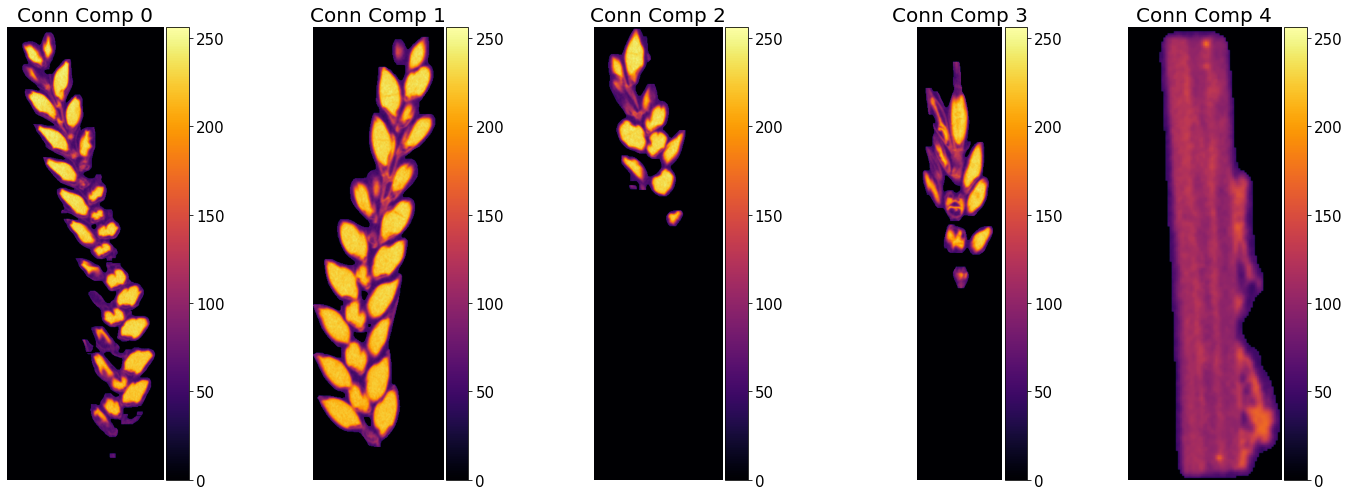

In [51]:
fig, ax = plt.subplots(1, 5, figsize=(20,7))

for i in range(len(cc)):
    mag = ax[i].imshow(cc[i], origin='lower', cmap='inferno', vmin=0, vmax=2**(cc[i].dtype.itemsize*8))
    ax[i].set_title('Conn Comp {}'.format(i), fontsize=20)
    cbar = plt.colorbar(mag, ax=ax[i], pad=0.01);
    cbar.ax.tick_params(labelsize=15) 
    ax[i].axis('off');
fig.tight_layout();

# Foo

In [53]:
raw = tf.imread(tiff_file)
raw = raw[mask].reshape(shape)
raw = raw[mask2].reshape(shape2)

In [54]:
draw = dict()
for key in boxes:
    x,y,z,w,h,d,l = boxes[key]
    draw[key] = raw[z:(z+d), y:(y+h), x:(x+w)]
    filename = dst + 'raw_' + str(key)
    tf.imwrite(filename, draw[key], photometric='minisblack', compress=3)

In [55]:
dd = []
dd.append(draw[conn_comp[0]][:, 96,:])
dd.append(draw[conn_comp[1]][:, 99,:])
dd.append(draw[conn_comp[2]][:, 75,:])
dd.append(draw[conn_comp[3]][:, 77,:])
dd.append(draw[conn_comp[4]][:, 14,:])

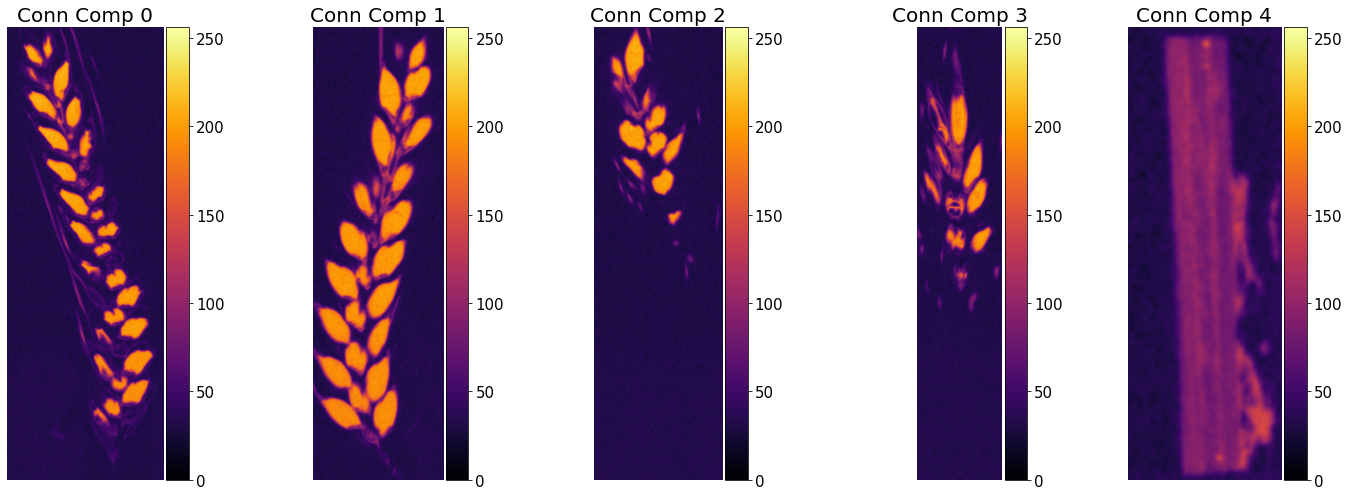

In [56]:
fig, ax = plt.subplots(1, 5, figsize=(20,7))

for i in range(len(dd)):
    mag = ax[i].imshow(dd[i], origin='lower', cmap='inferno', vmin=0, vmax=2**(dd[i].dtype.itemsize*8))
    ax[i].set_title('Conn Comp {}'.format(i), fontsize=20)
    cbar = plt.colorbar(mag, ax=ax[i], pad=0.01);
    cbar.ax.tick_params(labelsize=15) 
    ax[i].axis('off');
fig.tight_layout();